<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#The-Data" data-toc-modified-id="The-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The Data</a></span><ul class="toc-item"><li><span><a href="#Comparing-to-Other-Datasets" data-toc-modified-id="Comparing-to-Other-Datasets-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comparing to Other Datasets</a></span></li><li><span><a href="#Bimodal-Justification-—-Empirical-Distribution-Fitting" data-toc-modified-id="Bimodal-Justification-—-Empirical-Distribution-Fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Bimodal Justification — Empirical Distribution Fitting</a></span><ul class="toc-item"><li><span><a href="#Binned-Fitting" data-toc-modified-id="Binned-Fitting-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Binned Fitting</a></span></li></ul></li></ul></li><li><span><a href="#Motivation-—-Synthetic-Spectra-from-Hydrodynamic-Numerical-Models" data-toc-modified-id="Motivation-—-Synthetic-Spectra-from-Hydrodynamic-Numerical-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Motivation — Synthetic Spectra from Hydrodynamic Numerical Models</a></span></li><li><span><a href="#Method" data-toc-modified-id="Method-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Parameter-Estimation---Grid-Search" data-toc-modified-id="Parameter-Estimation---Grid-Search-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Parameter Estimation - Grid Search</a></span></li><li><span><a href="#Case-1---Two-Types:-One-Spherical-and-One-Asymmetric" data-toc-modified-id="Case-1---Two-Types:-One-Spherical-and-One-Asymmetric-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Case 1 - Two Types: One Spherical and One Asymmetric</a></span></li><li><span><a href="#Case-2---One-Type:-All-Asymmetric" data-toc-modified-id="Case-2---One-Type:-All-Asymmetric-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Case 2 - One Type: All Asymmetric</a></span></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Discussion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Sampling-a-Uniform-Sphere-from-3D-to-2D" data-toc-modified-id="Sampling-a-Uniform-Sphere-from-3D-to-2D-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Sampling a Uniform Sphere from 3D to 2D</a></span></li></ul></li></ul></div>

The following report pertains to the paper (Zhang Keto, Zheng WeiKang, Brink Thomas, et al 20XX) from hereon called PAPER to be properly cited after publication.

In [13]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9

In [14]:
sns.set(style='ticks', context='poster', color_codes=True, rc={
    'figure.figsize': [10, 6],
    'legend.fontsize': 18,
    'lines.linewidth' : 5,
    'patch.linewidth': 2.2,
    'hatch.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
})

In [15]:
import warnings
warnings.filterwarnings('ignore')

# Introduction



Type Ia supernovae (SNe Ia) are generally thought to be the thermonuclear disruption of a carbon-oxygen white-dwarf star (WD) in a binary system (see, e.g., Hillebrandt & Niemeyer 2000 for a review), but their formation scenarios and exact progenitor systems are still ambiguous. The photospheric velocity of SNe Ia measured from the strong Si II λ6355 absorption line in their spectrum (e.g., Silverman et al. 2012) at the time of peak brightness is an important parameter for studying the various properties of SNe Ia. The ejecta velocity distribution is also a possible clue for revealing asymmetries in SN Ia explosions. Recent studies reveal that the distribution of SN Ia velocity does not originate from a uniform class. [Wang, X. et al. (2013)](https://arxiv.org/abs/1303.2601) and [Zheng et al. (2018)](https://arxiv.org/abs/1712.01495) show that there exists a subclass of SNe Ia with high velocities (Figures 1 and 2), indicating a different origin for some SNe Ia.

Asymmetric SN Ia explosions could cause different measured ejecta velocities observed from different lines of sight. We intend to model the ejecta velocity of SNe Ia seen from different lines of sight through numerical simulations to test if the simulated velocity distribution could match the observed velocity distribution. We expect the model to demonstrate properties of velocity, ejecta size, and rarity of the high-velocity ejecta compared to the low-velocity. The results of the simulations will be a random sample of the velocity distribution to be compared with the real data.

Due to the limited time alloted for this project, a few descoping option was used. The original method of parameter estimation was MCMC which the posterior of the parameters were difficult to interpret. Further convergence test was needed therefore we decided MCMC was too time consuming. Parameter estimation was descoped from MCMC to grid search which provides a single set of best estimated parameters which would produced a smaller posterior population than if MCMC was used.


# The Data

The dataset comes from the kaepora database ([Siebert, M. R. et al. 2019](https://academic.oup.com/mnras/article/486/4/5785/5484870)). It consists of 311 Si II velocities from SNe Ia.

Justification for this dataset over others were discussed on the PAPER and analyzed here on the next subsection.

,v_siII,v_siII_err,z
kaepora,,,
2006td,10812.60,300.000,0.015880
1996z,12142.10,233.568,0.007575
1996x,11173.10,222.453,0.006945
1996c,10689.10,222.453,0.027000
2005m,8093.94,231.052,0.022000


,v_siII,v_siII_err,z
count,311.000000,302.000000,291.000000
mean,11464.053312,252.692500,0.022419
std,1352.070748,48.301207,0.014516
min,7359.470000,220.440000,0.000677
25%,10635.450000,222.689500,0.012223
50%,11234.900000,233.762500,0.019900
75%,11998.850000,260.649250,0.030912
max,15969.300000,616.588000,0.079665


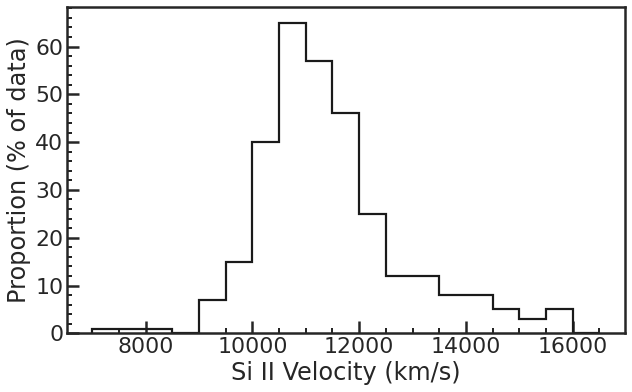

In [16]:
from dataloader import import_kaepora  # See dataloader.py::clean_data for data cleaning process

data = import_kaepora()

# Plot
bins = np.arange(7000, 17000, 500)
plt.hist(data['v_siII'],
         bins=bins,
         color='k',
         histtype='step',
         label='Observed')

# Plot config
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Proportion (% of data)')

display(data.head())
display(data.describe())

plt.savefig(
    'results/velocity_dist_raw.eps',
    orientation='landscape',
    format='eps',
)

## Comparing to Other Datasets

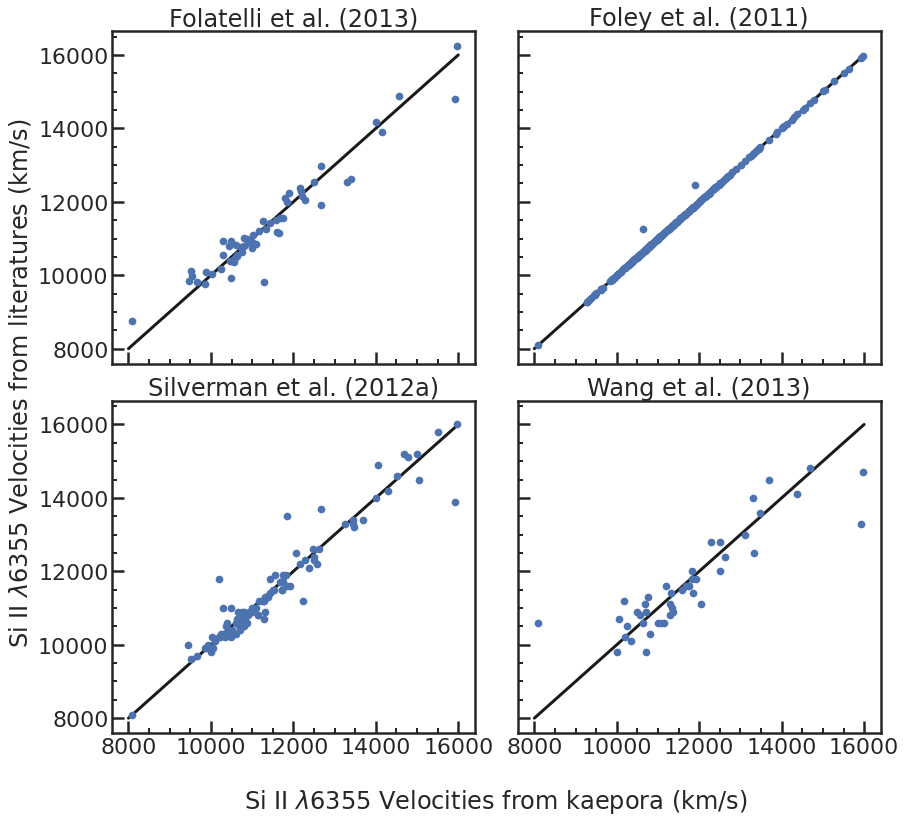

In [32]:
from dataloader import import_folatelli13, import_foley11, import_wang13, import_zheng18

datasets = [
    import_folatelli13(),
    import_foley11(),
    import_wang13(),
    import_zheng18()
]
labels = [
    'Folatelli et al. (2013)', 
    'Foley et al. (2011)',
    'Silverman et al. (2012a)', 
    'Wang et al. (2013)', 'Zheng et al. (2018)'
]

# Plot
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows,
                        ncols,
                        figsize=(7 * ncols, 6 * nrows),
                        sharex=True,
                        sharey=True)

for i in range(nrows * ncols):
    ax = axs[i // ncols, i % ncols]
    d = datasets[i]

    # 45deg line
    ax.plot([8000, 16000], [8000, 16000], 'k', linewidth=3, zorder=1)

    overlap = set(data.index).intersection(set(datasets[i].index))
    ax.scatter(data.loc[overlap, 'v_siII'],
               d.loc[overlap, 'v_siII'],
               s=30,
               zorder=2)
    ax.set_title(f'{labels[i]}')

# Outer Element
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                which='both',
                top=False,
                bottom=False,
                left=False,
                right=False)

plt.xlabel('Si II $\lambda$6355 Velocities from kaepora (km/s)', labelpad=30)
plt.ylabel('Si II $\lambda$6355 Velocities from literatures (km/s)', labelpad=40)

plt.tight_layout(pad=0.5)
plt.savefig('results/overlap_data.eps', orientation='landscape', format='eps')

## Bimodal Justification &mdash; Empirical Distribution Fitting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


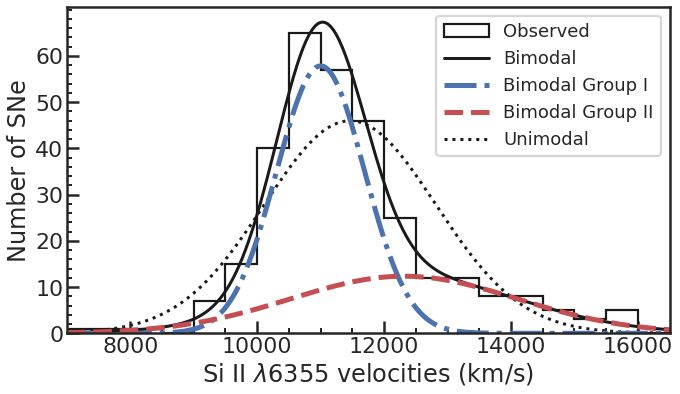

In [18]:
from scipy.optimize import curve_fit
from models import gaussian, bimodal_gaussian

UNIMODAL_PARAMS = np.loadtxt('results/unimodal_params.csv', delimiter=',')
BIMODAL_PARAMS = np.loadtxt('results/bimodal_params.csv', delimiter=',')

x = data['v_siII']
N = len(x)
bins = np.arange(7000, 17000, 500)
bin_width = np.mean(bins[1:] - bins[:-1])
xrange = np.linspace(bins.min(), bins.max(), 200)
plt.hist(x, bins=bins, color='k', histtype='step', label='Observed')

# Unimodal Gaussian
plt.plot(xrange, N*bin_width*gaussian(xrange, *UNIMODAL_PARAMS), 'k', linestyle='dotted', linewidth=3, zorder=0, label='Unimodal')

# Bimodal Gaussian
g1 = BIMODAL_PARAMS[4]
lv_dist = g1 * gaussian(xrange, *BIMODAL_PARAMS[0:2])
hv_dist = (1-g1) * gaussian(xrange, *BIMODAL_PARAMS[2:4])
plt.plot(xrange, N*bin_width*(lv_dist + hv_dist), 'k', linewidth=3, zorder=0, label='Bimodal')
plt.plot(xrange, N*bin_width*lv_dist, 'b', linestyle='dashdot', zorder=1, label='Bimodal Group I')
plt.plot(xrange, N*bin_width*hv_dist, 'r', linestyle='dashed', zorder=1, label='Bimodal Group II')

# Plot config
plt.xlim(bins.min(), bins.max())

plt.yticks(np.arange(0, 66, 10))

plt.xlabel('Si II $\lambda$6355 velocities (km/s)')
plt.ylabel('Number of SNe')
handles, labels = ax.get_legend_handles_labels()
handles, legends = plt.gca().get_legend_handles_labels()
order = [4, 1, 2, 3, 0]
plt.legend([handles[i] for i in order], [legends[i] for i in order], loc='upper right', handlelength=2.5)

plt.tight_layout()
plt.savefig('results/velocity_dist.eps', orientation='landscape', format='eps', )

In [19]:
# x = data['v_siII']
# bins = np.arange(7000, 17000, 500)
# plt.hist(x, density=True, bins=bins, color='k', histtype='step', label='Observed')

# # Unimodal Gaussian
# xrange = np.linspace(bins.min(), bins.max(), 200)
# plt.plot(xrange, gaussian(xrange, *UNIMODAL_PARAMS), '--k', lw=4, label='Unimodal')

# g1 = BIMODAL_PARAMS[4]
# lv_dist = g1 * gaussian(xrange, *BIMODAL_PARAMS[0:2])
# hv_dist = (1-g1) * gaussian(xrange, *BIMODAL_PARAMS[2:4])
# plt.plot(xrange, lv_dist + hv_dist, 'k', lw=4, label='Bimodal')

# # Plot config
# plt.xlim(bins.min(), bins.max())
# plt.ylim(0, 25 / 500 / 100)

# yticks = plt.yticks()[0] * 500 * 100
# ytickslabel = [f'{tick:.2g}' for tick in yticks]
# plt.yticks(plt.yticks()[0], ytickslabel)

# plt.xlabel('Si II Velocity (km/s)')
# plt.ylabel('Proportion (% of data)')
# plt.legend(loc='upper right', fontsize=18)

# # Save results
# plt.tight_layout(pad=0)
# plt.savefig('results/velocity_dist_sum.eps', orientation='landscape', format='eps', )

In [20]:
# dataset = [import_folatelli13(), import_foley11(), import_wang13(), import_zheng18()]
# labels = ['Folatelli et al. (2013)',
#  'Foley et al. (2011)',
#  'Silverman et al. (2012a)',
#  'Wang et al. (2013)',
#  'Zheng et al. (2018)']

# markers = [
#     'o', 's', '^', 'x'
# ]
# y_offset = 3000

# plt.figure(figsize=(10,10))
# for i, d in enumerate(dataset):
#     overlap = set(data.index).intersection(set(d.index))
#     plt.plot([8000, 16000], [8000 + y_offset*(4-i), 16000 + y_offset*(4-i)], 'k', linewidth=3, zorder=1)
#     plt.scatter(
#         data.loc[overlap, 'v_siII'], 
#         d.loc[overlap, 'v_siII'] + y_offset*(4-i), 
#         marker=markers[i], s=20, zorder=2, label=labels[i])
    

# ticks = bins[::2]
# tickslabel = np.array([f'{tick:.0f}' for tick in bins[::2]])
# plt.xticks(ticks, tickslabel)

# plt.xlabel('KAEPORA Si II Velocity (km/s)')
# plt.ylabel('Si II Velocity + Constant (km/s)')

# plt.legend()
# plt.savefig('results/overlap_data.eps', orientation='landscape', format='eps');

In [21]:
def unimodal_lnlike(x, params):
    mu, sigma = params
    prob = gaussian(x, mu, sigma)
    lnl = sum(np.log(prob))
    return lnl



def bimodal_lnlike(x, params):
    mu1, sigma1, mu2, sigma2, g = params
    prob1 = gaussian(x, mu1, sigma1)
    prob2 = gaussian(x, mu2, sigma2)
    prob = g * prob1 + (1 - g) * prob2
    lnl = sum(np.log(prob))
    return lnl


def aic(lnl, nparams):
    return 2  * nparams - 2 * lnl


def aicc(lnl, n, nparams):
    c = (2*nparams**2 + 2*nparams) / (n - nparams - 1)
    return aic(lnl, nparams) + c

# Best Fit Parameters
_ = pd.DataFrame([UNIMODAL_PARAMS, BIMODAL_PARAMS], columns=['$\mu_1$', '$\sigma_1$', '$\mu_2$', '$\sigma_2$', '$g$'], index=['Unimodal', 'Bimodal'])
display(_)


# Performance Metrics
unimodal_lnl = unimodal_lnlike(data['v_siII'], UNIMODAL_PARAMS)
bimodal_lnl = bimodal_lnlike(data['v_siII'], BIMODAL_PARAMS)
_ = pd.DataFrame(
    [
        [unimodal_lnl, -2*unimodal_lnl, aicc(unimodal_lnl, 3, len(data))],
        [bimodal_lnl, -2*bimodal_lnl, aicc(bimodal_lnl, 5, len(data))],
    ],
    columns=['Log-Likelihood', '$\chi^2$', 'AICc'],
    index=['Unimodal', 'Bimodal']
)

diff = _.loc['Unimodal', :] - _.loc['Bimodal', :]
diff.name = 'Difference'
_ = _.append(diff)
display(_)


,$\mu_1$,$\sigma_1$,$\mu_2$,$\sigma_2$,$g$
Unimodal,11464.053312,1349.895251,NaN,NaN,NaN
Bimodal,10999.685302,693.101891,12312.438942,1777.630832,0.646264


,Log-Likelihood,$\chi^2$,AICc
Unimodal,-2682.910172,5365.820344,5359.781509
Bimodal,-2647.779830,5295.559660,5285.429367
Difference,-35.130342,70.260683,74.352142


$\chi^2$ in the "Difference" row is the likelihood ratio $\chi^2$ statistics derived from the likelihood values. The number of degrees of freedom is the difference in the number of free parameters between the bimodal and unimodal model (i.e., 3). Because $\chi^2_3 > 7.82$ (p-value < 5%), we consider the improvement from the unimodal to the bimodal fit to be significant. The AICc provides a metric that penalizes the number of parameters and small sample size to prevent overfitting. Because the $\text{AICc} > 6$, we consnider the improvement to be very significant.

In [22]:
_ = pd.DataFrame([
    np.array([unimodal_lnl, *UNIMODAL_PARAMS]),
    np.array([bimodal_lnl, *BIMODAL_PARAMS])
],
    columns = [r"$L_\text{max}$", "$\mu_1$", "$\sigma_1$", "$\mu_2$", "$\sigma_2$", "$g$",]
)

_.style.format(("{:#.0f}"))

,$L_\text{max}$,$\mu_1$,$\sigma_1$,$\mu_2$,$\sigma_2$,$g$
0,-2683.,11464.,1350.,nan,nan,nan
1,-2648.,11000.,693.,12312.,1778.,1.


### Binned Fitting

As a sanity check to maximum likelihood, midpoint values of binned data was fitted using ordinary least squares.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


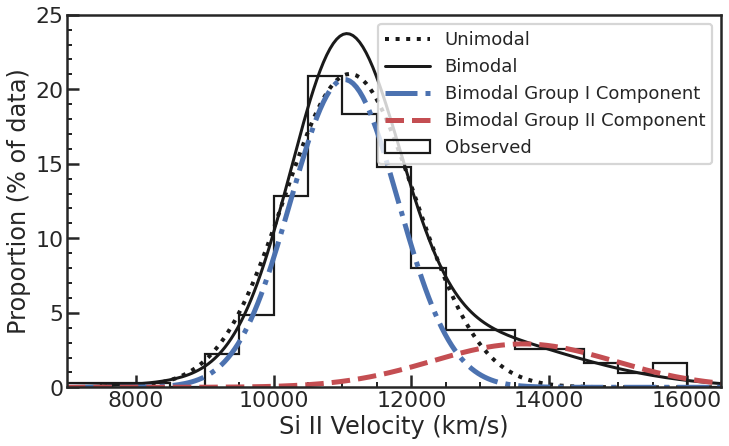

In [23]:
BINNED_UNIMODAL_PARAMS = np.loadtxt('results/binned_unimodal_params.csv', delimiter=',')
BINNED_BIMODAL_PARAMS = np.loadtxt('results/binned_bimodal_params.csv', delimiter=',')

x = data['v_siII']
bins = np.arange(7000, 17000, 500)
plt.hist(x, density=True, bins=bins, color='k', histtype='step', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
plt.plot(xrange, gaussian(xrange, *BINNED_UNIMODAL_PARAMS), 'k', linestyle='dotted', linewidth=4, zorder=0, label='Unimodal')

# Bimodal Gaussian
g1 = BINNED_BIMODAL_PARAMS[4]
## Group I
lv_dist = g1 * gaussian(xrange, *BINNED_BIMODAL_PARAMS[0:2])
plt.plot(xrange, lv_dist + hv_dist, 'k', linewidth=3, zorder=0, label='Bimodal')
## Group II
hv_dist = (1-g1) * gaussian(xrange, *BINNED_BIMODAL_PARAMS[2:4])
## Group I + Group II
plt.plot(xrange, lv_dist, 'b', linestyle='dashdot', zorder=1, label='Bimodal Group I Component')

plt.plot(xrange, hv_dist, 'r', linestyle='dashed', zorder=1, label='Bimodal Group II Component')

# Plot config
plt.xlim(bins.min(), bins.max())
plt.ylim(0, 25 / 500 / 100)

yticks = plt.yticks()[0] * 500 * 100
ytickslabel = [f'{tick:.2g}' for tick in yticks]
plt.yticks(plt.yticks()[0], ytickslabel)

plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Proportion (% of data)')
plt.legend(loc='upper right', fontsize=18, handlelength=2.5)

# Save results
plt.tight_layout(pad=0)
plt.savefig('results/binned_velocity_dist.eps', orientation='landscape', format='eps', )

Calculating the chi-square statistics for the binned fitting,

In [24]:
def chi2_statistics(observed_count, expected_count):
    summand = (observed_count - expected_count)**2 / expected_count
    return np.sum(summand)

observed_count, bins = np.histogram(data['v_siII'], bins=30)
bin_midpoints = (bins[1:] + bins[:-1]) / 2
bin_width = np.mean(bin_midpoints[1:] - bin_midpoints[:-1])

# Unimodal Gaussian
expected_count = np.sum(observed_count) * bin_width * gaussian(bin_midpoints, *BINNED_UNIMODAL_PARAMS)
unimodal_chi2 = chi2_statistics(observed_count, expected_count)

# Bimodal Gaussian
expected_count = np.sum(observed_count) * bin_width * bimodal_gaussian(bin_midpoints, *BINNED_BIMODAL_PARAMS)
bimodal_chi2 = chi2_statistics(observed_count, expected_count)

_ = pd.DataFrame([
    np.array([unimodal_chi2, 2, *BINNED_UNIMODAL_PARAMS, None, None, None]),
    np.array([bimodal_chi2, 5, *BINNED_BIMODAL_PARAMS])
],
                 columns=[
                     "$\chi^2$",
                     "DOF",
                     "$\mu_1$",
                     "$\sigma_1$",
                     "$\mu_2$",
                     "$\sigma_2$",
                     "$g$",
                 ])
_


,$\chi^2$,DOF,$\mu_1$,$\sigma_1$,$\mu_2$,$\sigma_2$,$g$
0,40214.538517,2.0,11107.005371,948.377394,NaN,NaN,NaN
1,876.576474,5.0,11027.873611,779.629106,13624.234718,1318.633898,0.807512


# Motivation &mdash; Synthetic Spectra from Hydrodynamic Numerical Models

,$\theta_c$,$\sigma$,$v_c$,$\sigma$,$\Delta_v$,$\sigma$
Kasen et al.,99.530773,8.070400,11723.807709,202.738806,5684.086737,988.641820
Townsley et al.,98.018631,3.653168,11113.082711,111.565640,5226.785506,427.139156


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


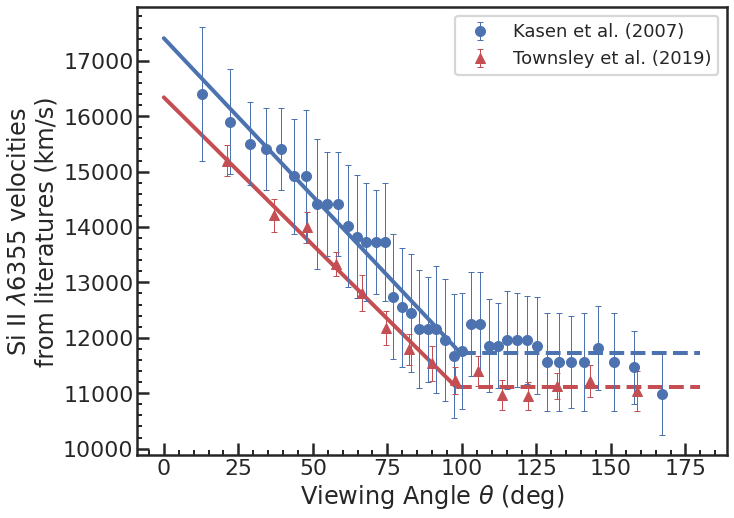

In [27]:
from dataloader import import_kasen07, import_townsley19

kasen_model = import_kasen07()
townsley_model = import_townsley19()


def piecewise_linear(x, x0, y0, m1):
    l1 = (m1 * x) + (y0 - (m1 * x0))
    l2 = y0

    return np.choose(x <= x0, [l2, l1])


def quadrature(x, y):
    return np.sqrt(x**2 + y**2)


def multiply_uncertainty(x, dx, y, dy):
    z = x * y
    dz = np.abs(z * quadrature(dx / x, dy / y))
    return dz


x = np.linspace(0, 180, 1000)
fig = plt.figure(figsize=(10, 7))

# Kasen et al. (2007)
plt.errorbar(kasen_model['viewing_angle'],
             kasen_model['v_siII'],
             yerr=kasen_model['v_siII_err'],
             fmt='o',
             markersize=10,
             elinewidth=1,
             capsize=3,
             capthick=1,
             zorder=2,
             label='Kasen et al. (2007)')
params, _ = curve_fit(piecewise_linear,
                      kasen_model['viewing_angle'],
                      kasen_model['v_siII'],
                      sigma=kasen_model['v_siII_err'],
                      absolute_sigma=True,
                      p0=[100, 12000, -4000 / 60])
errors = np.sqrt(np.diag(_))
kasen_results = pd.DataFrame([[
    params[0], errors[0], params[1], errors[1], -params[2] * params[0],
    multiply_uncertainty(params[0], errors[0], params[2], errors[2])
]],
                             columns=[
                                 r"$\theta_c$",
                                 '$\sigma$',
                                 "$v_c$",
                                 '$\sigma$',
                                 "$\Delta_v$",
                                 '$\sigma$',
                             ],
                             index=["Kasen et al."])
kasen_errors = pd.DataFrame(
    [errors],
    columns=[r"$\theta_c$", "$v_c$", "$\Delta_v$"],
    index=["Kasen et al."],
)

plt.plot(x[x <= params[0]],
         piecewise_linear(x, *params)[x <= params[0]],
         color='b',
         lw=4,
         zorder=1)
plt.plot(x[x > params[0]],
         piecewise_linear(x, *params)[x > params[0]],
         color='b',
         lw=4,
         zorder=1,
         ls='--')

# Townsley et al. (2019)
plt.errorbar(townsley_model['viewing_angle'],
             townsley_model['v_siII'],
             yerr=townsley_model['v_siII_err'],
             fmt='^',
             markersize=10,
             elinewidth=1,
             capsize=3,
             capthick=1,
             color='r',
             zorder=2,
             label='Townsley et al. (2019)')
params, _ = curve_fit(piecewise_linear,
                      townsley_model['viewing_angle'],
                      townsley_model['v_siII'],
                      sigma=townsley_model['v_siII_err'],
                      absolute_sigma=True,
                      p0=[100, 12000, -4000 / 60])
errors = np.sqrt(np.diag(_))
townsley_results = pd.DataFrame([[
    params[0], errors[0], params[1], errors[1], -params[2] * params[0],
    multiply_uncertainty(params[0], errors[0], params[2], errors[2])
]],
                                columns=[
                                    r"$\theta_c$",
                                    '$\sigma$',
                                    "$v_c$",
                                    '$\sigma$',
                                    "$\Delta_v$",
                                    '$\sigma$',
                                ],
                                index=["Townsley et al."])

plt.plot(x[x <= params[0]],
         piecewise_linear(x, *params)[x <= params[0]],
         color='r',
         lw=4,
         zorder=1)
plt.plot(x[x > params[0]],
         piecewise_linear(x, *params)[x > params[0]],
         color='r',
         lw=4,
         zorder=1,
         ls='--')

# Plot config
plt.xlabel(r'Viewing Angle $\theta$ (deg)')
plt.ylabel('Si II $\lambda$6355 velocities\nfrom literatures (km/s)')
plt.tight_layout(pad=0)
plt.legend()

display(pd.concat([kasen_results, townsley_results]))

plt.savefig(
    'results/velocity_synthetic_spectra.eps',
    orientation='landscape',
    format='eps',
)

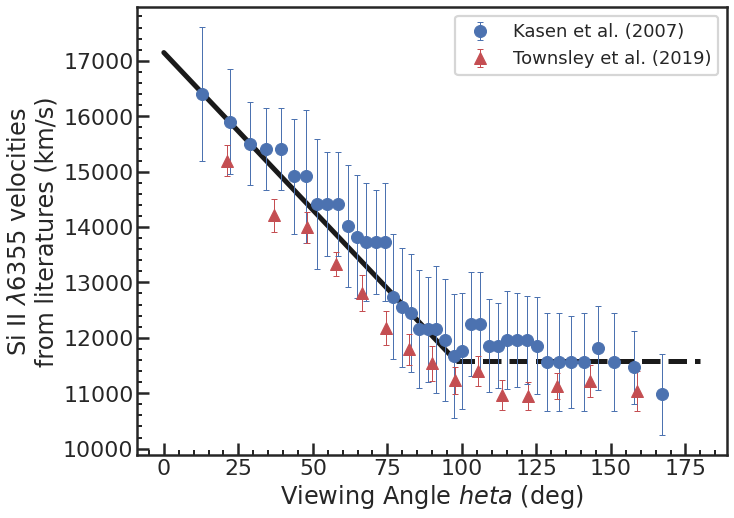

In [28]:
params, _ = curve_fit(piecewise_linear, np.concatenate([kasen_model['viewing_angle'], townsley_model['viewing_angle']]), np.concatenate([kasen_model['v_siII'], townsley_model['v_siII']]), p0=[100, 12000, -4000/60])

x = np.linspace(0, 180,1000)
fig = plt.figure(figsize=(10, 7))

plt.errorbar(kasen_model['viewing_angle'], kasen_model['v_siII'], yerr=kasen_model['v_siII_err'], 
             fmt='o', elinewidth=1, capsize=3, capthick=1, zorder=2, label='Kasen et al. (2007)')
plt.errorbar(townsley_model['viewing_angle'], townsley_model['v_siII'], yerr=townsley_model['v_siII_err'], 
             fmt='^', elinewidth=1, capsize=3, capthick=1, color='r', zorder=2, label='Townsley et al. (2019)')
plt.plot(x[x <= params[0]], piecewise_linear(x, *params)[x <= params[0]], color='k', lw=5, zorder=1)
plt.plot(x[x > params[0]], piecewise_linear(x, *params)[x > params[0]], color='k', lw=5, zorder=1, ls='--')

plt.xlabel('Viewing Angle $\theta$ (deg)')
plt.ylabel('Si II $\lambda$6355 velocities\nfrom literatures (km/s)')
plt.tight_layout(pad=0)
plt.legend()

# Method

Assumptions:

* Velocity of the Si II as a function of line of sight $\phi$ around the photosphere is inspired by the results of [2] and [3] which supports a monotonic decrease of velocity from its maximum (chosen to be at $\phi = 0$)

* Velocities are symmetric along one axis where $v(\phi) = v(-\phi)$.

* We make the simplify the monotonic decrease to be linear in addition to a cutoff at some angle $\theta$ such that,

    $$
    v(\phi) = v_L + \begin{cases} \frac{\theta - \phi}{\theta}\Delta v\\ 0 \end{cases}
    $$
    
    Where $v_L$ is distributed from the low velocity Gaussian component fit of the data and $\Delta v$ and $\theta$ are treated as parameters.


2. [Kasen D. and Plewa T. 2007](https://iopscience.iop.org/article/10.1086/516834)
3. [Townsley, D. M., Miles, B. J., Shen, K. J. et al. 2019](https://iopscience.iop.org/article/10.3847/2041-8213/ab27cd)

## Parameter Estimation - Grid Search

Using the simulation above, the best estimated parameters is determined by a grid search amongst all two parameters. The range of the grid is given below. The interval syntax is range(low, high, step):

$$
\begin{align}
\theta  &\in \text{range}(0, 180, 5) \quad \text{[deg]}\\
\Delta v &\in \text{range}(3000,~ 7500,~ 500) \quad \text{[km/s]}
\end{align}
$$

In total, $N=|\theta|\cdot|\Delta v|$ sets of parameters were simulated. Each simulation was scored by the Kolmogorov-Smirov (KS) test.

## Case 1 - Two Types: One Spherical and One Asymmetric

In [29]:
# Import results
import pickle as pkl

with open('results/scores_v2.pkl', 'rb') as f:
    scores = pkl.load(f)

ks = scores['ks']
sort_idx = np.argsort(ks)

pvalue = scores['pvalue']
pvalue = pvalue[sort_idx]
ks = ks[sort_idx]

params = scores['params'][sort_idx]
v_sim = scores['v_sim'][sort_idx]

df = pd.DataFrame([
         ks,
         pvalue
     ], index=['ks', 'pvalue']).T

df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalue,theta,delta_v
0,0.032173,0.905302,111,6000
1,0.032451,0.899740,110,6300
2,0.032593,0.896853,111,6300
3,0.032783,0.892913,112,5900
4,0.032823,0.892075,111,6200


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


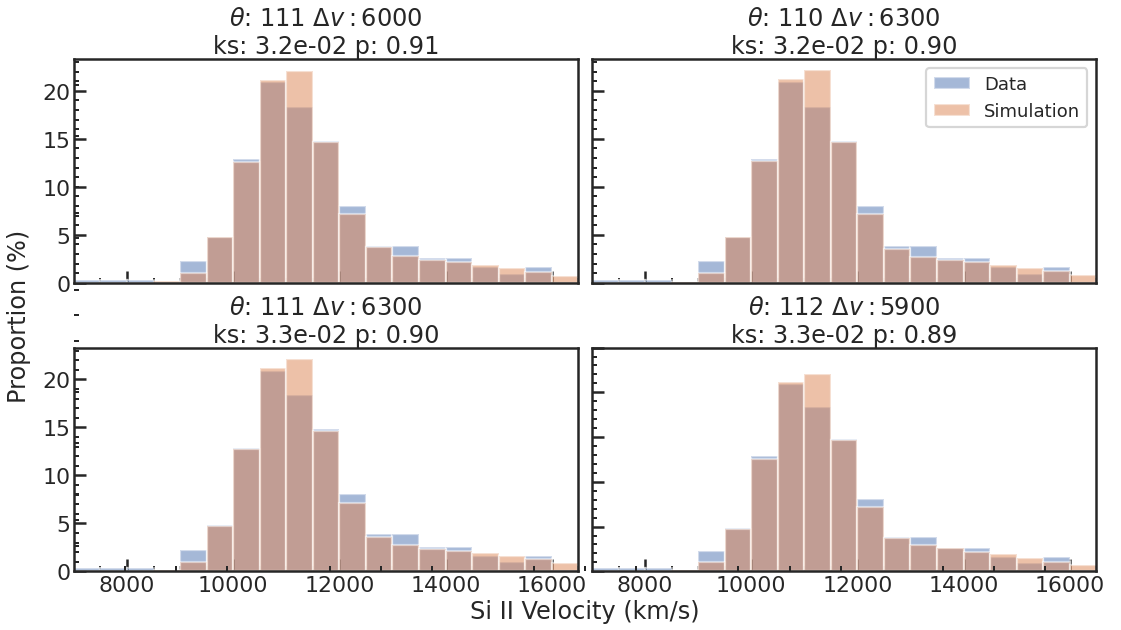

In [30]:
from scipy.stats import kstest, norm, ks_2samp

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel("Proportion (%)")

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(7000, 17000, 500)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param = params[i]
    
#     bimodal_params = np.loadtxt('bimodal_params.csv', delimiter=',')
#     lv_params = bimodal_params[:2]
#     hv_params = bimodal_params[2:-1]
#     mixing_param = bimodal_params[-1]
#     param = params[i]
    
    
    # Data
    l1 = ax.hist(data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    
    # LV Component
    
    # HV Component Data Fit
#     ax.plot(xrange, gaussian(xrange, *hv_params) * (1-mixing_param), '--b', label="Data HV Fit")
    
    # HV Simulation
    # Use HV from simulation and LV from sampling data fit
#     hv_samp = hvs[i]
    
    l2 = ax.hist(v_sim[i], bins, density=True, alpha=0.5, label="Simulation")
    
    # HV Component Simulation Fit
    # Gaussian fit on the simulation
#     ydata, xdata = np.histogram(hv_samp, bins=np.arange(0.8, 1.75, 0.1) * 10, density=True)
#     xdata = (xdata[:-1] + xdata[1:]) / 2
#     opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(hv_samp), np.std(hv_samp)])
#     ax.plot(xrange, gaussian(xrange, *opt) * (1-mixing_param), '--r', label="Simulation HV Fit")

    
    # Plot config
    ax.set_title(f"$\\theta$: {param['theta']} $\Delta v: ${param['delta_v']}\nks: {ks[i]:.1e} p: {pvalue[i]:.2f}")
    ax.set_xlim(bins.min(), bins.max())
    yticks = ax.get_yticks() * 500 * 100
    yticks = np.arange(yticks.min(), yticks.max() + 1, 5) / (500 * 100)
    ytickslabel = [f'{tick:.2g}' for tick in yticks * 500 * 100]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytickslabel)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc='upper right')
plt.tight_layout(pad=0)
plt.savefig('results/grid_search_results_v2.eps', format='eps')

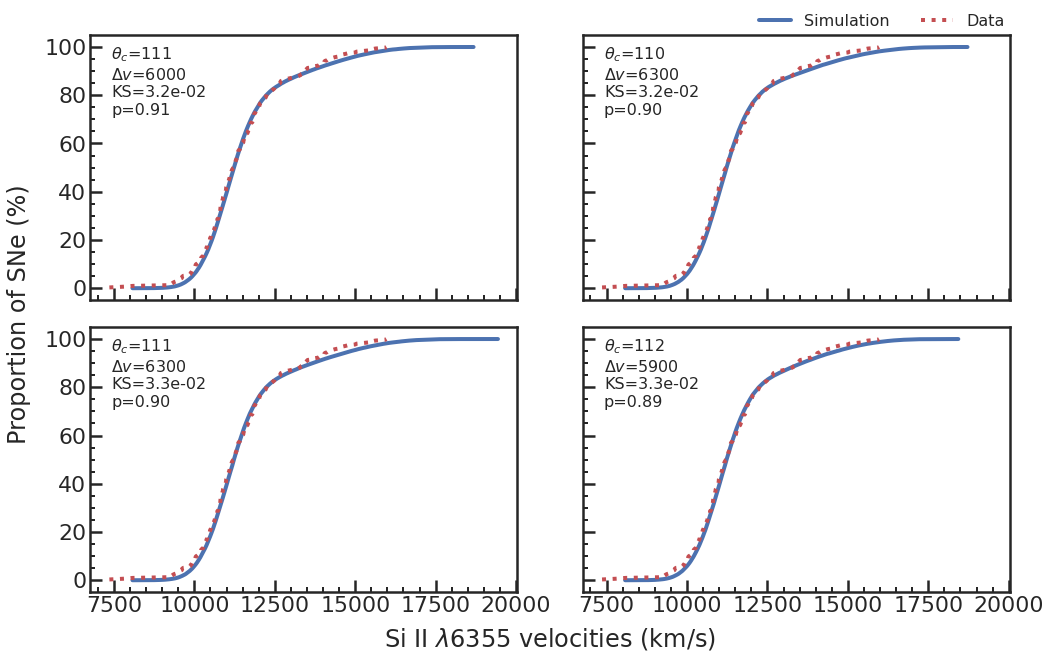

In [34]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II $\lambda$6355 velocities (km/s)', labelpad=10)
plt.ylabel("Proportion of SNe (%)", labelpad=20)

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param=params[i]

#     ax.hist(data['v_siII'], density=True, bins=30, histtype='step', cumulative=True, label='Data')
#     ax.hist(v_sim[i], density=True, bins=30, color='r', histtype='step', cumulative=True, label='Simulation')
    ax.plot(np.sort(v_sim[i]), np.arange(1, len(v_sim[i])+1)/len(v_sim[i])*100, 
            linewidth=4, label='Simulation')
    ax.plot(np.sort(data['v_siII']), np.arange(1, len(data)+1)/len(data)*100, 
            color='r', linestyle='dotted', linewidth=4, label='Data')
    
    # Plot config
    ax.text(x=0.05, y=0.7,
        s=f"$\\theta_c$={param['theta']}\n$\Delta v$={param['delta_v']}\nKS={ks[i]:.1e}\np={pvalue[i]:.2f}", 
        horizontalalignment="left", fontsize=16, transform=ax.transAxes)
#     ax.set_xticks(np.arange(7000, 20000, 2000), minor=True)
                 
#     yticks = np.arange(0, 101, 25) / 100
#     ax.set_yticks(yticks)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc=(0.72, 1), frameon=False, ncol=2, fontsize=16)
plt.tight_layout()
plt.savefig('results/grid_search_cumulative_results_v2.eps', format='eps', dpi=800)

In [20]:
with open('results/all_scores_v2.pkl', 'rb') as f:
    all_scores = pkl.load(f)

params = all_scores.pop('params')
df = pd.DataFrame(all_scores)
df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalue,theta,delta_v
0,0.193751,1.555419e-10,0,3000
1,0.193741,1.559160e-10,1,3000
2,0.193681,1.581797e-10,2,3000
3,0.193651,1.593235e-10,3,3000
4,0.193541,1.635872e-10,4,3000


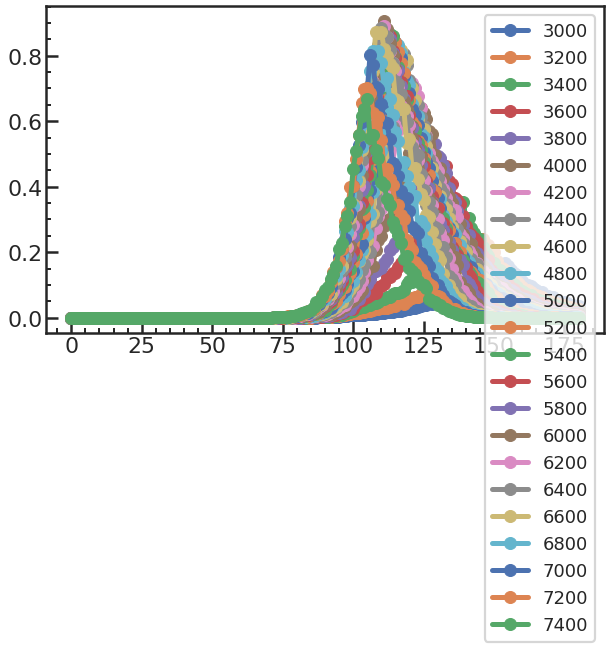

In [21]:
_values = np.sort(df['delta_v'].unique())

for cut in _values[::2]:
    _ = df.loc[df['delta_v'] == cut, :].sort_values('theta')
    plt.plot(_['theta'], _['pvalue'], '-o', label=str(cut))

plt.legend();

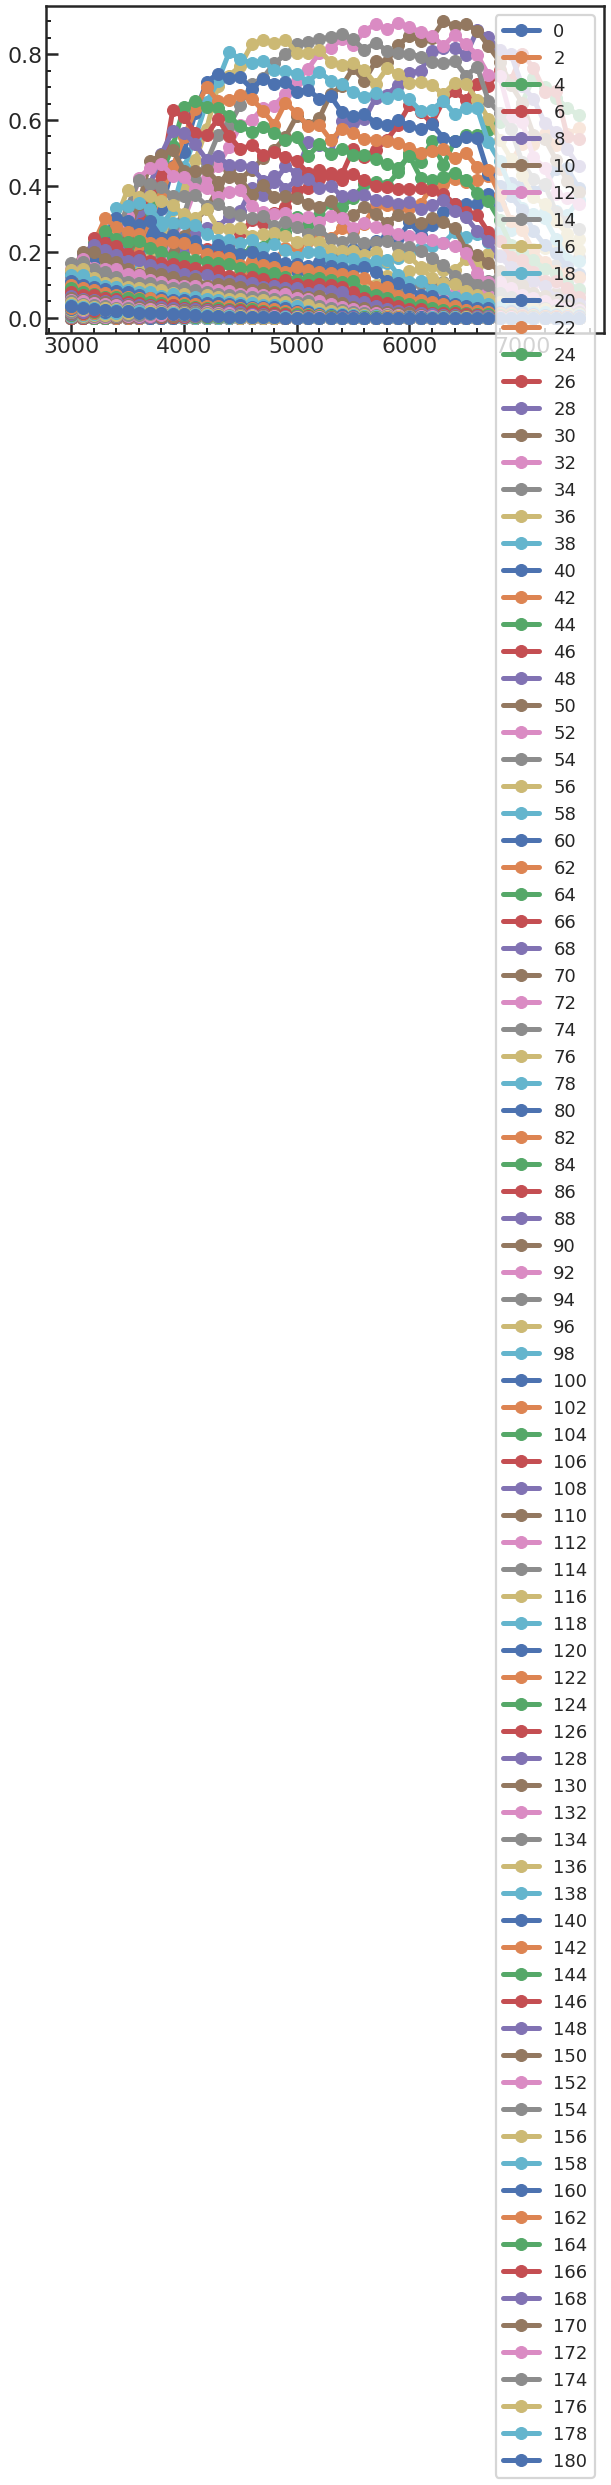

In [22]:
_values = np.sort(df['theta'].unique())

for cut in _values[::2]:
    _ = df.loc[df['theta'] == cut, :].sort_values('delta_v')
    plt.plot(_['delta_v'], _['pvalue'], '-o', label=str(cut))

plt.legend();

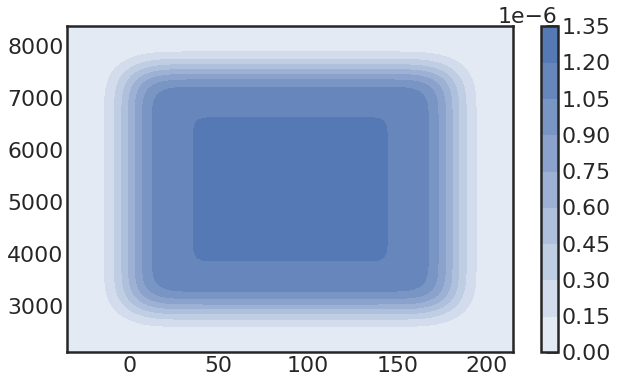

In [23]:
sns.kdeplot(df[['theta', 'delta_v', 'pvalue']], cbar=True, shade=True, n_levels=10)

In [24]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')


In [25]:
np.sqrt(df[['theta', 'delta_v', 'pvalue']].cov())

,theta,delta_v,pvalue
theta,52.253,0.000,1.682
delta_v,0.000,1327.672,3.403
pvalue,1.682,3.403,0.188


Text(0.5, 1.0, '5.37e+03 +/- 1168.95')

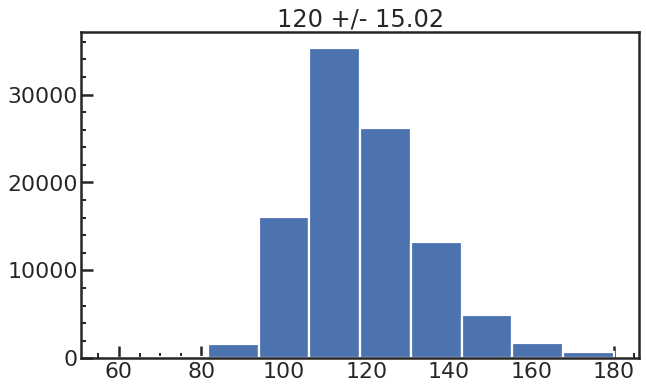

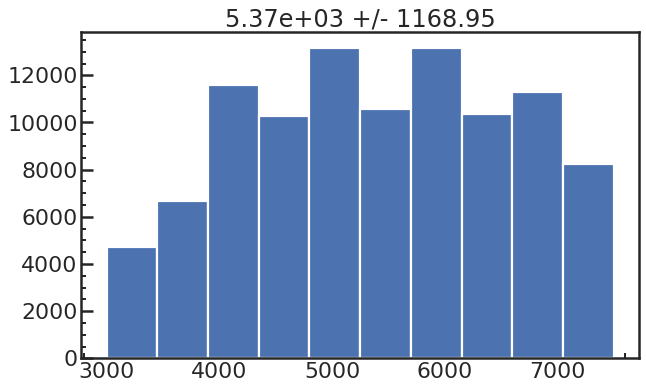

In [26]:
def sampling(rep, *kwargs):
    def simulate(sample_size=10000):
        return np.random.choice(np.arange(df.shape[0]), p=df['pvalue']/df['pvalue'].sum(), size=sample_size)
    
    results = []
    for i in range(rep):
        sample = simulate(*kwargs)
        results = np.append(results, sample)
        
    return results

_ = sampling(10)
_y = df['theta'][_]
plt.hist(_y)
plt.title(f"{np.mean(_y):.3g} +/- {np.std(_y):.2f}")
plt.figure()
_y = df['delta_v'][_]
plt.hist(_y)
plt.title(f"{np.mean(_y):.3g} +/- {np.std(_y):.2f}")

Plotted above is the top KS scoring simulation. The bottom plot is the same plot as the previous figure. The top plot is the cumulative distirbution of the bottom.

## Case 2 - One Type: All Asymmetric

In [27]:
# Import results
import pickle as pkl

with open('results/scores_v3.pkl', 'rb') as f:
    scores = pkl.load(f)

ks = scores['ks']
sort_idx = np.argsort(ks)

pvalue = scores['pvalue']
pvalue = pvalue[sort_idx]
ks = ks[sort_idx]

params = scores['params'][sort_idx]
v_sim = scores['v_sim'][sort_idx]

df = pd.DataFrame([
         ks,
         pvalue
     ], index=['ks', 'pvalue']).T

df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalue,theta,delta_v
0,0.033,0.890,60,6400
1,0.033,0.885,60,6700
2,0.033,0.885,59,7000
3,0.034,0.875,59,7100
4,0.034,0.872,59,6900


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


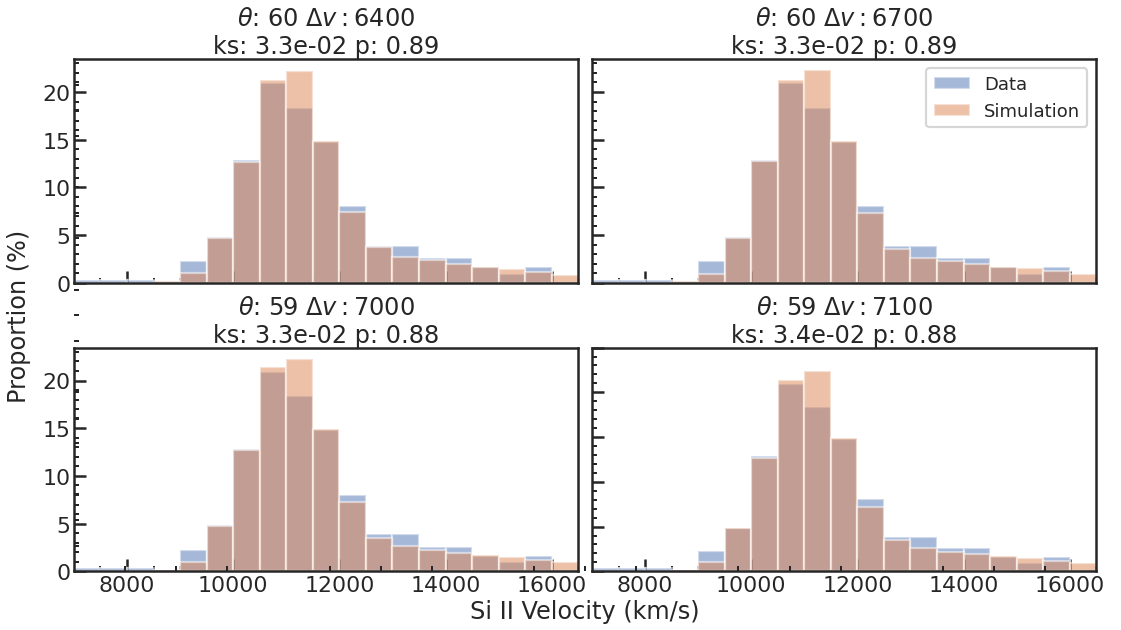

In [28]:
from scipy.stats import kstest, norm, ks_2samp

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel("Proportion (%)")

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(7000, 17000, 500)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param = params[i]
    
#     bimodal_params = np.loadtxt('bimodal_params.csv', delimiter=',')
#     lv_params = bimodal_params[:2]
#     hv_params = bimodal_params[2:-1]
#     mixing_param = bimodal_params[-1]
#     param = params[i]
    
    
    # Data
    l1 = ax.hist(data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    
    # LV Component
    
    # HV Component Data Fit
#     ax.plot(xrange, gaussian(xrange, *hv_params) * (1-mixing_param), '--b', label="Data HV Fit")
    
    # HV Simulation
    # Use HV from simulation and LV from sampling data fit
#     hv_samp = hvs[i]
    
    l2 = ax.hist(v_sim[i], bins, density=True, alpha=0.5, label="Simulation")
    
    # HV Component Simulation Fit
    # Gaussian fit on the simulation
#     ydata, xdata = np.histogram(hv_samp, bins=np.arange(0.8, 1.75, 0.1) * 10, density=True)
#     xdata = (xdata[:-1] + xdata[1:]) / 2
#     opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(hv_samp), np.std(hv_samp)])
#     ax.plot(xrange, gaussian(xrange, *opt) * (1-mixing_param), '--r', label="Simulation HV Fit")

    
    # Plot config
    ax.set_title(f"$\\theta$: {param['theta']} $\Delta v: ${param['delta_v']}\nks: {ks[i]:.1e} p: {pvalue[i]:.2f}")
    ax.set_xlim(bins.min(), bins.max())
    yticks = ax.get_yticks() * 500 * 100
    yticks = np.arange(yticks.min(), yticks.max() + 1, 5) / (500 * 100)
    ytickslabel = [f'{tick:.2g}' for tick in yticks * 500 * 100]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytickslabel)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc='upper right')
plt.tight_layout(pad=0)
plt.savefig('results/grid_search_results_v3.eps', format='eps')

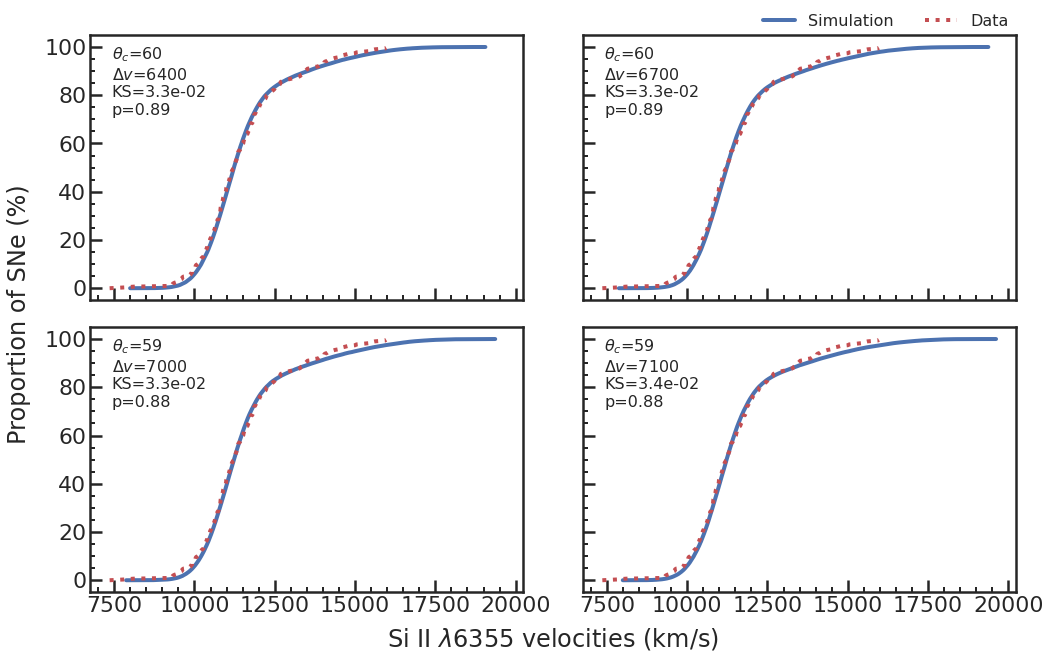

In [31]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II $\lambda$6355 velocities (km/s)', labelpad=10)
plt.ylabel("Proportion of SNe (%)", labelpad=20)

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param=params[i]

#     ax.hist(data['v_siII'], density=True, bins=30, histtype='step', cumulative=True, label='Data')
#     ax.hist(v_sim[i], density=True, bins=30, color='r', histtype='step', cumulative=True, label='Simulation');
    ax.plot(np.sort(v_sim[i]), np.arange(len(v_sim[i]))/len(v_sim[i])*100, 
            label='Simulation', linewidth=4)
    ax.plot(np.sort(data['v_siII']), np.arange(len(data))/len(data)*100, 
            label='Data', color='r', linestyle='dotted', linewidth=4)
    
    # Plot config
    ax.text(x=0.05, y=0.7,
        s=f"$\\theta_c$={param['theta']}\n$\Delta v$={param['delta_v']}\nKS={ks[i]:.1e}\np={pvalue[i]:.2f}", 
        horizontalalignment="left", fontsize=16, transform=ax.transAxes)
#     ax.set_xticks(np.arange(7000, 20000, 2000), minor=True)
                 
#     yticks = np.arange(0, 101, 25) / 100
#     ax.set_yticks(yticks)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc=(0.72, 1), frameon=False, ncol=2, fontsize=16)
plt.tight_layout()
plt.savefig('results/grid_search_cumulative_results_v3.eps', format='eps', dpi=800)

Ks_2sampResult(statistic=0.10354983922829582, pvalue=0.003103801821182211)

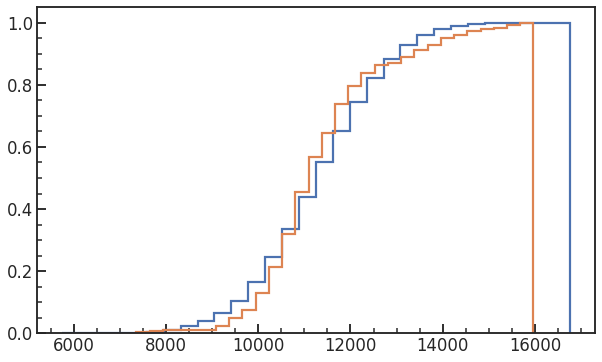

In [58]:
_dist = norm(*UNIMODAL_PARAMS[0:2])
plt.hist(_dist.rvs(10000), bins=30, histtype='step', cumulative=True, density=True)
plt.hist(data['v_siII'], bins=30, histtype='step', cumulative=True, density=True)
ks_2samp(_dist.rvs(10000), data['v_siII'])

In [60]:
with open('results/all_scores_v3.pkl', 'rb') as f:
    all_scores = pkl.load(f)

params = all_scores.pop('params')
df = pd.DataFrame(all_scores)
df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalue,theta,delta_v
0,0.194,0.000,0,3000
1,0.194,0.000,1,3000
2,0.194,0.000,2,3000
3,0.193,0.000,3,3000
4,0.193,0.000,4,3000


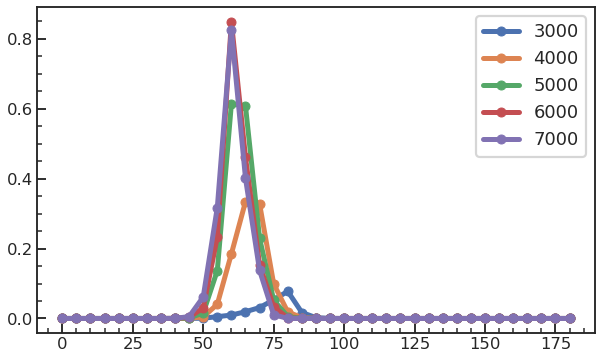

In [220]:
_values = np.sort(df['delta_v'].unique())

for cut in _values[::2]:
    _ = df.loc[df['delta_v'] == cut, :].sort_values('theta')
    plt.plot(_['theta'], _['pvalue'], '-o', label=str(cut))

plt.legend();

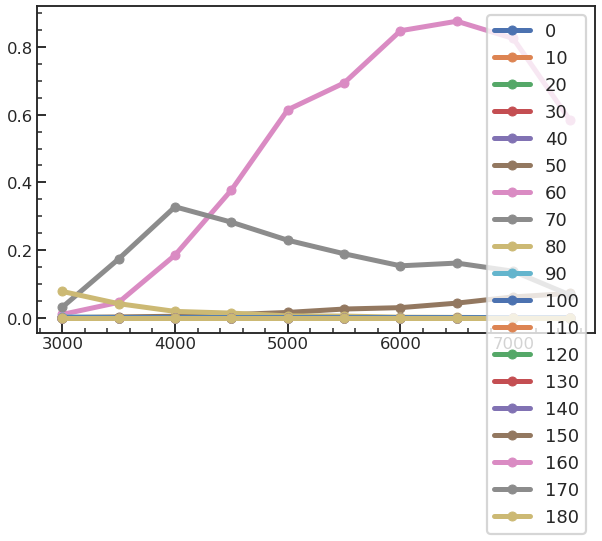

In [221]:
_values = np.sort(df['theta'].unique())

for cut in _values[::2]:
    _ = df.loc[df['theta'] == cut, :].sort_values('delta_v')
    plt.plot(_['delta_v'], _['pvalue'], '-o', label=str(cut))

plt.legend();

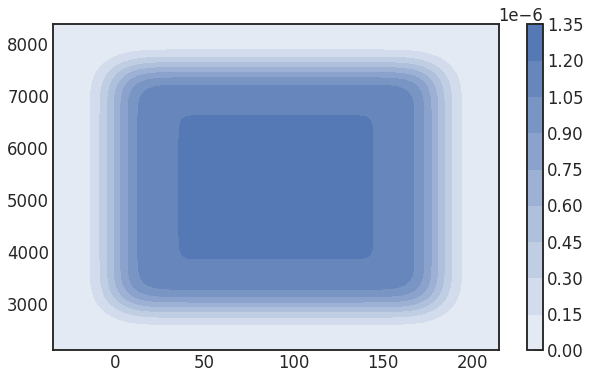

In [61]:
sns.kdeplot(df[['theta', 'delta_v', 'pvalue']], cbar=True, shade=True, n_levels=10)

In [69]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
np.sqrt(df[['theta', 'delta_v', 'pvalue']].cov())

,theta,delta_v,pvalue
theta,52.253,0.000,nan
delta_v,0.000,1327.672,3.864
pvalue,nan,3.864,0.127


Text(0.5, 1.0, '5646.89 +/- 1150.05')

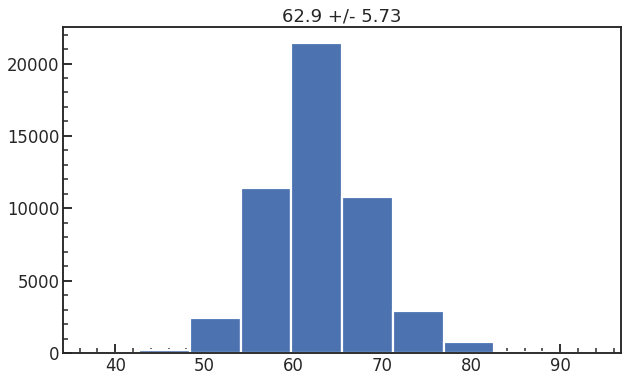

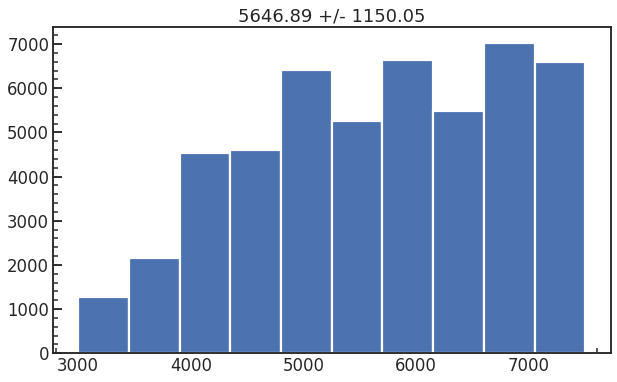

In [64]:
def sampling(rep, *kwargs):
    def simulate(sample_size=10000):
        return np.random.choice(np.arange(df.shape[0]), p=df['pvalue']/df['pvalue'].sum(), size=sample_size)
    
    results = []
    for i in range(rep):
        sample = simulate(*kwargs)
        results = np.append(results, sample)
        
    return results

_ = sampling(5)
_y = df['theta'][_]
plt.hist(_y)
plt.title(f"{np.mean(_y):.3g} +/- {np.std(_y):.2f}")
plt.figure()
_y = df['delta_v'][_]
plt.hist(_y)
plt.title(f"{np.mean(_y):3g} +/- {np.std(_y):.2f}")

In [77]:
np.abs(5500-(5200+5700)/2)/np.sqrt(1200**2 + np.sqrt(9**2 + 4**2))

0.0416665241781354

Plotted above is the top KS scoring simulation. The bottom plot is the same plot as the previous figure. The top plot is the cumulative distirbution of the bottom.

# Discussion

The distinction in Si II velocity distribution may be described by asymmetries in SNe Ia's ejecta. We produced a two-dimensional simulation under the assumption that the ejecta asymmetries is only angular (i.e., the ejecta is anisotropic) where the there exist a angular region on the photospheric shell that has a velocity higher than the remaining shell. These two region are labeled as high-velocity ejecta (HV) and low-velocity ejecta (LV). We assume for a given SN Ia, its LV ejecta velocity is constant while the HV ejecta velocity follows a linear uniformily increasing function with minimum value of the LV ejecta velocity. The best performing simulations resulted in reasonable and consistent values with Kasen D. & Plewa T. (2007) and Townsley et al. (2019). 

# References

Hillebrandt, W., & Niemeyer, J. C. 2000, ARA&A, 38, 191

Kasen D. & Plewa T. 2007, ApJ, 662, 1

Levanon, N., & Soker, N. 2019, arXiv:1901.05057

Polin, A., Nugent, P. E., & Kasen, D. 2019, ApJ, 873, 1

Silverman, J. M., Kong, J. J., Filippenko, A. V., et al. 2012, MNRAS, 425, 1819

Townsley, D. M., Miles, B. J., Shen, K. J. et al. 2019, ApJ, 878, 2

Wang, X., Wang, L., & Filippenko, A. V. 2013, Science, 340, 6129

Zheng, W., Kelly, P. L., & Filippenko, A. V. 2018, ApJ, 858, 104

# Appendix

## Sampling a Uniform Sphere from 3D to 2D

For a uniformly distributed sphere in 3D, the projection down to 2D on the x-z plane where $\phi$ (the colongitude angle) disappears, the probability distribution as a function of $\theta$ (the colatitude angle) is,

$$
P(\theta) = \frac{1}{2} \sin{\theta}
$$

Sampling this distribution requires a trick where we take the uniform random variable $U ~ [0,1]$ and apply the transformation:

$$
u \in U\\
\theta = \arccos(2u - 1)
$$

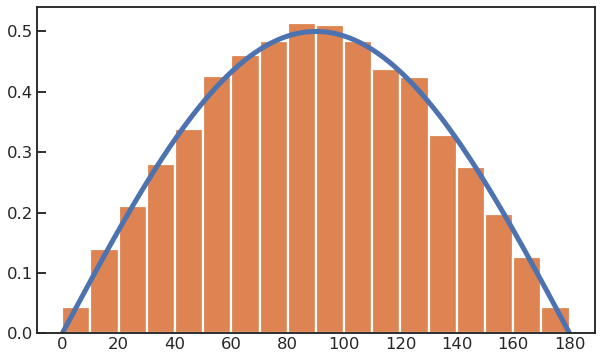

In [54]:
def pdf(theta):
    return -np.sin(theta)/2

# Plot the true PDF
theta = np.linspace(0,np.pi,10000)

# Sample with special trick
v = np.random.uniform(0,1, 10000)
theta_samples = np.arccos(2*v - 1)
# theta_samples = np.pi/2 - theta_samples
# theta_samples[theta_samples < 0] = theta_samples[theta_samples < 0]

bins = np.radians(np.arange(0,181,10))
plt.plot(theta, np.abs(pdf(theta)))
plt.hist(theta_samples, density=True, bins=bins);
plt.xticks(ticks=bins[::2], labels=[f"{xtick/np.pi * 180:.0f}" for xtick in bins[::2]]);